<a href="https://colab.research.google.com/github/jang-jin/ML-Class/blob/master/2_sell_time_predict_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# import function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"R^2 : {r2_score(y_test, y_pred)}")
    print(f"RMSE : {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

def select_coin_index(X_data, y_data, coin_index):
    X_data_df = X_data.loc[X_data['coin_index'] == coin_index]
    y_data_df = y_data.loc[y_data['coin_index'] == coin_index]

    X_data_value = X_data_df.values.reshape((-1,1380,12))
    y_data_value = y_data_df.values.reshape((-1,120,12))

    data_value = np.concatenate((X_data_value, y_data_value), axis=1)[:, :, 3:4] # 시가만 추출
    print(data_value.shape)

    return data_value

def train_val_split(data, T, test_size=0.3, train_len=1380, test_len=120):
    X_train = np.empty((0, T, data.shape[2]))
    y_train = np.empty((0, data.shape[2]))
    X_val = np.empty((0, T, data.shape[2]))
    y_val = np.empty((0, data.shape[2]))
    X_test = np.empty((0, T, data.shape[2]))
    y_test = np.empty((0, data.shape[2]))

    val_len = train_len
    test_len = train_len + test_len
    train_len = int(train_len * (1-test_size))
    
    print("Train Data Preprocessing")
    for t in tqdm(range(train_len-T)):
        temp_x = data[:, t:t+T, :]
        temp_y = data[:, t+T, :]
        X_train = np.concatenate((X_train, temp_x), axis=0)
        y_train = np.concatenate((y_train, temp_y), axis=0)

    print("Validation Data Preprocessing")
    for t in tqdm(range(train_len-T, val_len-T)):
        temp_x = data[:, t:t+T, :]
        temp_y = data[:, t+T, :]
        X_val = np.concatenate((X_val, temp_x), axis=0)
        y_val = np.concatenate((y_val, temp_y), axis=0)
    
    print("Test Data Preprocessing")
    for t in tqdm(range(val_len-T, test_len-T)):
        temp_x = data[:, t:t+T, :]
        temp_y = data[:, t+T, :]
        X_test = np.concatenate((X_test, temp_x), axis=0)
        y_test = np.concatenate((y_test, temp_y), axis=0)

    print()
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

def print_prediction(model, X_test, y_test, data_size, is_dl=False, sample_size=3, is_difference=False):
    y_pred = model.predict(X_test)
    result = np.empty((data_size, 0))

    if is_dl:
        test = X_test[:data_size,:,:]
        for _ in tqdm(range(120)):
            y_prediction = model.predict(test).reshape(-1, 1)
            test = np.concatenate((test[:, 1:, :], y_prediction.reshape(-1, 1, 1)), axis=1)
            result = np.concatenate((result, y_prediction), axis=1)
    else:
        test = X_test[:data_size,:]
        for _ in tqdm(range(120)):
            y_prediction = model.predict(test).reshape(-1, 1)
            test = np.concatenate((test[:, 1:], y_prediction), axis=1)
            result = np.concatenate((result, y_prediction), axis=1)
    

    final_test = y_test.reshape(120, -1).T
    final_pred = y_pred.reshape(120, -1).T
    final_result = result

    if is_difference:
        final_test = difference_transform(final_test)
        final_pred = difference_transform(final_pred)
        final_result = difference_transform(final_result)

    for i in range(sample_size):
        plt.plot(final_test[i,:], label='real')
        plt.plot(final_pred[i,:], label='pred')
        plt.plot(final_result[i,:], label='result')
        plt.legend()
        plt.show()

def difference_transform(test_difference):
    data_size = test_difference.shape[0]
    result = np.empty((data_size, 0))
    test = np.ones((data_size))

    for i in tqdm(range(120)):
        test = test + test_difference[:, i]
        result = np.concatenate((result, test.reshape(data_size, 1)), axis=1)
        
    return result

In [3]:
# data load
PATH = '/content/drive/MyDrive/Colab Notebooks/DACON_ai_bit_trader_contest'

train_x_df = pd.read_csv(PATH+"/data/train_x_df.csv")
train_y_df = pd.read_csv(PATH+"/data/train_y_df.csv")
test_x_df = pd.read_csv(PATH+"/data/test_x_df.csv")

train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [ ]:
# coin_index 0인 데이터만 추출
train_0 = select_coin_index(train_x_df, train_y_df, 0)

(937, 1500, 1)


In [ ]:
# 60분으로 다음 1분을 예측하는 전처리
T = 60
X_train, X_val, X_test, y_train, y_val, y_test = train_val_split(train_0, T)

  5%|▍         | 45/905 [00:00<00:01, 449.53it/s]

Train Data Preprocessing


 11%|█▏        | 47/415 [00:00<00:00, 469.65it/s]

Validation Data Preprocessing


 38%|███▊      | 46/120 [00:00<00:00, 453.53it/s]

Test Data Preprocessing


100%|██████████| 120/120 [00:00<00:00, 126.05it/s]


(847985, 60, 1) (847985, 1)
(388855, 60, 1) (388855, 1)
(112440, 60, 1) (112440, 1)


##### RF

In [ ]:
start = time.time()

rf = RandomForestRegressor().fit(X_train[:100000,:,0], y_train[:100000,0])

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

time : 0시간 11분 27초


In [ ]:
# validation 점수
print_score(rf, X_val[:,:,0], y_val[:,0])

R^2 : 0.9947484866413041
RMSE : 0.0015358210939416786
MAPE : 0.08675074239322542


In [ ]:
# test 점수
print_score(rf, X_test[:,:,0], y_test[:,0])

R^2 : 0.9815220941218941
RMSE : 0.001610825860952239
MAPE : 0.08932694355539757


100%|██████████| 120/120 [00:02<00:00, 43.62it/s]


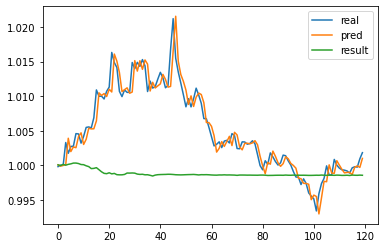

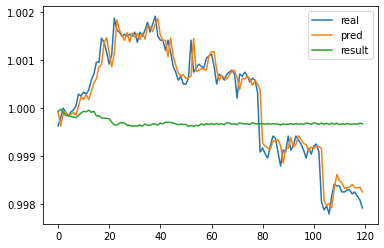

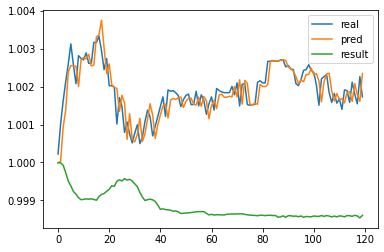

In [ ]:
# 결과 출력
print_prediction(rf, X_test[:,:,0], y_test[:,0], train_0.shape[0])

##### LSTM

In [ ]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm.add(LSTM(64))
lstm.add(Dense(1, activation='linear'))

lstm.compile(loss='mse', optimizer='adam')
lstm.summary()

lstm.fit(X_train[:100000,:,:], y_train[:100000,0],
         epochs=10,
         batch_size=128,
         validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 28s 24ms/step - loss: 0.0043 - val_loss: 1.3447e-05
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 1.4549e-05 - val_loss: 4.2541e-05
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 1.4929e-05 - val_loss: 5.0681e-05
Epoch 4/10
782/782 [==============================] - 17

In [ ]:
# validation 점수
print_score(lstm, X_val[:10000,:,:], y_val[:10000,0])

R^2 : 0.988815834387097
RMSE : 0.0031781871787661523
MAPE : 2.769069287692607


In [ ]:
# test 점수
print_score(lstm, X_test[:10000,:,:], y_test[:10000,0])

R^2 : 0.15469235376864765
RMSE : 0.003130515316151829
MAPE : 0.2876407085216124


100%|██████████| 120/120 [00:14<00:00,  8.15it/s]


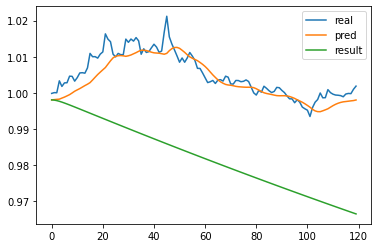

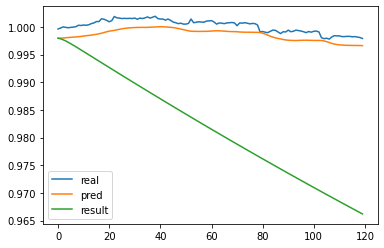

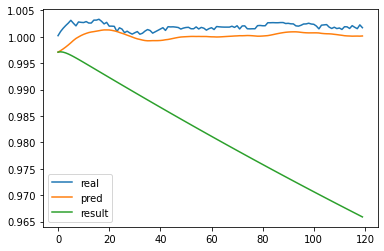

In [ ]:
# 결과 출력
print_prediction(lstm, X_test, y_test[:,0], train_0.shape[0], is_dl=True)

### 차분

In [ ]:
difference = 1
X_train, X_val, X_test, y_train, y_val, y_test = train_val_split((train_0[:, difference:, :] - train_0[:,:train_0.shape[1]-difference, :]), T, train_len=1380-difference, test_len=120)

  5%|▌         | 49/905 [00:00<00:01, 488.07it/s]

Train Data Preprocessing


 13%|█▎        | 54/414 [00:00<00:00, 517.24it/s]

Validation Data Preprocessing


 43%|████▎     | 52/120 [00:00<00:00, 511.58it/s]

Test Data Preprocessing


100%|██████████| 120/120 [00:00<00:00, 161.98it/s]


(847985, 60, 1) (847985, 1)
(387918, 60, 1) (387918, 1)
(112440, 60, 1) (112440, 1)


##### RF

In [ ]:
start = time.time()

rf = RandomForestRegressor().fit(X_train[:100000,:,0], y_train[:100000,0])

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

time : 1시간 45분 47초


In [ ]:
# validation 점수
print_score(rf, X_val[:,:,0], y_val[:,0])

R^2 : -0.03456842044085651
RMSE : 0.0014781215395524353
MAPE : inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
# test 점수
print_score(rf, X_test[:,:,0], y_test[:,0])

R^2 : -0.04255625699863286
RMSE : 0.0015634587163257034
MAPE : inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


100%|██████████| 120/120 [00:12<00:00,  9.54it/s]


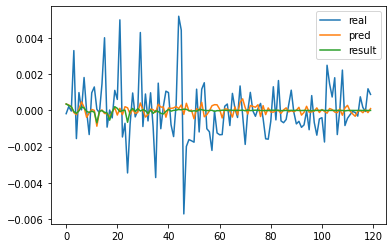

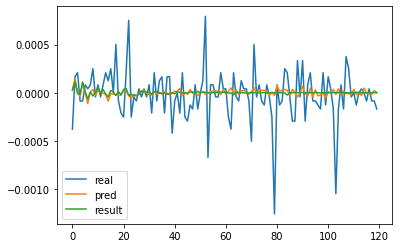

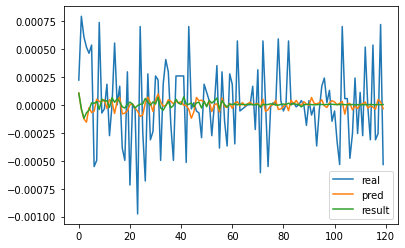

In [ ]:
# 결과 출력
print_prediction(rf, X_test[:,:,0], y_test[:,0], train_0.shape[0])

100%|██████████| 120/120 [00:00<00:00, 8420.18it/s]


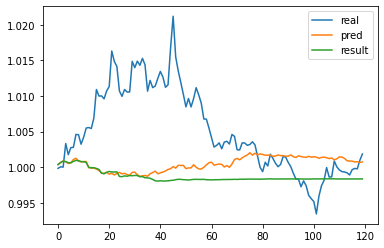

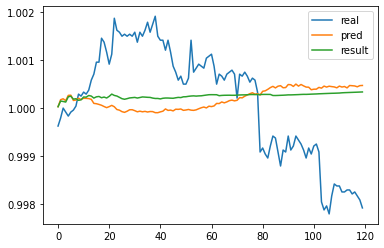

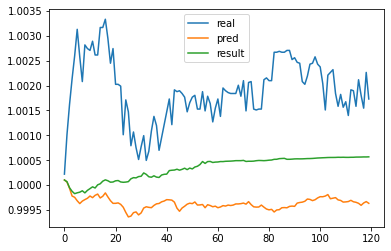

In [ ]:
print_prediction(rf, X_test[:,:,0], y_test[:,0], train_0.shape[0], is_difference=True)

##### LSTM

In [ ]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm.add(LSTM(64))
lstm.add(Dense(1, activation='linear'))

lstm.compile(loss='mse', optimizer='adam')
lstm.summary()

lstm.fit(X_train[:100000,:,:], y_train[:100000,0],
         epochs=10,
         batch_size=128,
         validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 21s 23ms/step - loss: 3.2277e-06 - val_loss: 2.1301e-06
Epoch 2/10
782/782 [==============================] - 17s 22ms/step - loss: 2.1509e-06 - val_loss: 2.1151e-06
Epoch 3/10
782/782 [==============================] - 17s 22ms/step - loss: 2.1576e-06 - val_loss: 2.2362e-06
Epoch 4/10
782/782 [==============================

In [ ]:
# validation 점수
print_score(lstm, X_val[:10000,:,:], y_val[:10000,0])

R^2 : -0.0020980960396728143
RMSE : 0.0014925807370015846


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE : inf


In [ ]:
# test 점수
print_score(lstm, X_test[:10000,:,:], y_test[:10000,0])

R^2 : -0.003152706544011119
RMSE : 0.0014495918204252094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE : inf


100%|██████████| 120/120 [00:14<00:00,  8.45it/s]


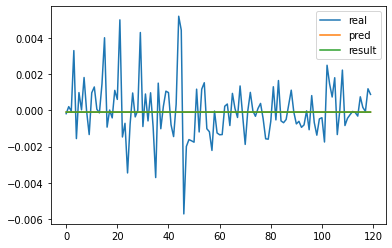

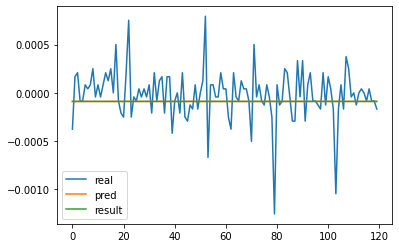

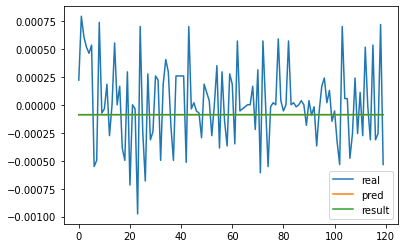

In [ ]:
# 결과 출력
print_prediction(lstm, X_test, y_test[:,0], train_0.shape[0], is_dl=True)

100%|██████████| 120/120 [00:00<00:00, 9245.68it/s]


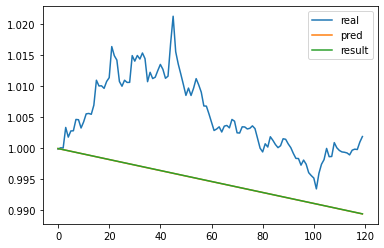

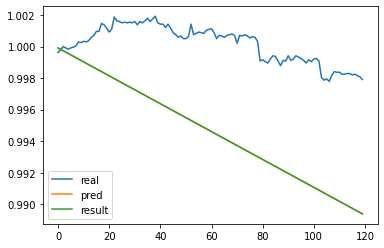

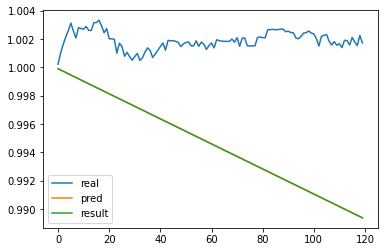

In [ ]:
print_prediction(lstm, X_test, y_test[:,0], train_0.shape[0], is_dl=True, is_difference=True)

### 기울기

In [4]:
train_x_value = train_x_df.values.reshape((-1,1380,12))
train_y_value = train_y_df.values.reshape((-1,120,12))

data_value = np.concatenate((train_x_value, train_y_value), axis=1)
print(data_value.shape)

(7661, 1500, 12)


In [5]:
N = 60

train = np.empty((data_value.shape[0], 0, data_value.shape[2]))
for i in range(0, data_value.shape[1], N):
    train = np.concatenate((train, (data_value[:, i+N-1:i+N, :] - data_value[:, i:i+1, :])/(N-1)), axis=1)
print(train.shape)

(7661, 25, 12)


In [6]:
X = train[:, :23, 3]
y = train[:, 23, 3]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [7]:
start = time.time()

rf = RandomForestRegressor().fit(X_train, y_train)

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

time : 0시간 0분 0초


In [8]:
# test 점수
print_score(rf, X_test, y_test)

R^2 : -2.0540902090582236e-05
RMSE : 0.0001972822329759345
MAPE : inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [9]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(1, activation='linear'))

lstm.compile(loss='mse', optimizer='adam')
lstm.summary()

lstm.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train,
         epochs=10,
         batch_size=128,
         validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
45/45 [==============================] - 8s 13ms/step - loss: 2.3602e-06 - val_loss: 1.6867e-07
Epoch 2/10
45/45 [==============================] - 0s 4ms/step - loss: 6.8150e-08 - val_loss: 3.8637e-08
Epoch 3/10
45/45 [==============================] - 0s 4ms/step - loss: 4.9532e-08 - val_loss: 3.9940e-08
Epoch 4/10
45/45 [==============================] - 0s 4ms/step - loss: 4.9625e-08 - val_loss: 3.8820e-08
Epoch 5/10
45/45 [==============================] - 0s 4ms/step - loss: 4.9439e-08 - val_lo

In [10]:
# test 점수
print_score(lstm, X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test)

R^2 : -0.004125410438285293
RMSE : 0.00019768671891610504
MAPE : inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


### 분류

In [ ]:
train_x_value = train_x_df.values.reshape((-1,1380,12))[:, :, 3]
train_y_value = train_y_df.values.reshape((-1,120,12))[:, -1, 3]
test_x_value = test_x_df.values.reshape((-1,1380,12))[:, :, 3]

print(train_x_value.shape)
print(train_y_value.shape)
print(test_x_value.shape)

(7661, 1380)
(7661,)
(535, 1380)


In [ ]:
N = 120
train_x = np.empty((train_x_value.shape[0], 0))
for i in range(60, train_x_value.shape[1], N):
    train_x = np.concatenate((train_x, (train_x_value[:, i+N-1:i+N] - train_x_value[:, i:i+1])/(N-1)), axis=1)
print(train_x.shape)
test_x = np.empty((test_x_value.shape[0], 0))
for i in range(60, test_x_value.shape[1], N):
    test_x = np.concatenate((test_x, (test_x_value[:, i+N-1:i+N] - test_x_value[:, i:i+1])/(N-1)), axis=1)
print(test_x.shape)

(7661, 11)
(535, 11)


In [ ]:
train_y = np.where(train_y_value >= 1, 1, 0)

In [ ]:
rf = RandomForestClassifier()
param = {'max_depth':[5, 7, 9, 11]}
gs = GridSearchCV(rf, param_grid=param, cv=5)
gs.fit(train_x, train_y)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 11}
0.5434024140791192


In [ ]:
svc = SVC()
param = {'C':[0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(svc, param_grid=param, cv=5)
gs.fit(train_x, train_y)
print(gs.best_params_)
print(gs.best_score_)

{'C': 10}
0.5394849430884339


In [ ]:
xgb = XGBClassifier()
param = {'max_depth':[5, 7, 9, 11]}
gs = GridSearchCV(xgb, param_grid=param, cv=5)
gs.fit(train_x, train_y)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 11}
0.5300871684558511


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=13)

lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
lstm.summary()

lstm.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train,
         epochs=10,
         batch_size=128,
         validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
45/45 [==============================] - 2s 13ms/step - loss: 0.6931 - acc: 0.5081 - val_loss: 0.6929 - val_acc: 0.5104
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.6930 - acc: 0.5105 - val_loss: 0.6929 - val_acc: 0.5104
Epoch 3/10
45/45 [==============================] - 0s 5ms/step - loss: 0.6931 - acc: 0.5105 - val_loss: 0.6929 - val_acc: 0.5104
Epoch 4/10
45/45 [==============================] - 0s 5ms/step - loss: 0.6930 - acc: 0.5105 - val_loss: 0.6929 - val_acc: 

In [ ]:
lstm.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test)

60/60 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.5104


[0.6929271221160889, 0.5104384422302246]

### 제출

In [ ]:
sample_submission = pd.read_csv(PATH+"/data/sample_submission.csv")
sample_submission.head()

,sample_id,buy_quantity,sell_time
0,7661,0,0
1,7662,0,0
2,7663,0,0
3,7664,0,0
4,7665,0,0


In [ ]:
model = gs.best_estimator_
sample_submission['buy_quantity'] = model.predict(test_x)
sample_submission['sell_time'] = np.where(model.predict(test_x) == 1, 119, 0)

In [ ]:
sample_submission.head()

,sample_id,buy_quantity,sell_time
0,7661,0,0
1,7662,0,0
2,7663,1,119
3,7664,1,119
4,7665,1,119


In [ ]:
sample_submission.to_csv(PATH+"/data/submit.csv", index=False)
# 10070.27641